## Introduction

Nous avons déjà utilisé des réseaux de neurones, avec [scikit-learn](https://thedatafrog.com/fr/reconnaissance-decriture-manuscrite-scikit-learn/) et [keras](https://thedatafrog.com/fr/premier-reseau-neurones-keras//). 

Pour l'instant, nous les avons traités comme des boîtes noires. 

Nous ne pouvons pas nous contenter de ça, car il est nécessaire de comprendre comment les réseaux de neurones fonctionnent avant de pouvoir les utiliser efficacement. 

Aujourd'hui, nous allons donc ouvrir la boîte, et disséquer un neurone.  

Pour ne pas trop compliquer les choses, nous utiliserons un réseau de neurones extrêmement simple, contenant un seul neurone. 

On peut s'imaginer qu'un tel "cerveau" doit être assez limité intellectuellement. Mais en fait, ce type de réseau correspond à un algorithme très utilisé en machine learning, **la régression logistique**.  

Dans cet article, vous apprendrez: 

* ce qu'il y a à l'intérieur d'un neurone, et en particulier ce qu'est la **fonction d'activation sigmoïde**;
* qu'un réseau de neurones n'est en fait qu'une fonction de ses variables d'entrée;
* qu'un seul neurone peut déjà être suffisant, et est équivalent à une régression logistique. 

**Pré-requis :**

Vous devriez déjà savoir ce que sont: 

* une fonction,
* une [exponentielle](https://fr.wikipedia.org/wiki/Fonction_exponentielle). 

Du point de vue technique, vous devez: 

* [installer Anaconda](https://thedatafrog.com/install-anaconda-data-science-python/), si ce n'est pas déjà fait.
* connaître un peu numpy, matplotlib, et scikit-learn. Pour une introduction, vous pouvez suivre [ce tuto]([scikit-learn](https://thedatafrog.com/fr/reconnaissance-decriture-manuscrite-scikit-learn/).

Comme d'habitude, on commence par télécharger et ouvrir ce notebook: 

* [téléchargez le dépôt contenant le notebook](https://github.com/cbernet/maldives/archive/master.zip)
* décompressez-le, par exemple vers `Downloads/maldives-master`
* lancez jupyter notebook depuis l'Anaconda Navigator
* dans votre navigateur, naviguez vers `Downloads/maldives-master/one_neuron`
* ouvrez `logistic_regression_1d_fr.ipynb`

À l'intérieur du notebook, importez les packages nécessaires: 

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Création de l'échantillon de données

Plutôt que d'importer un échantillon existant, créons-le nous-mêmes. 

L'échantillon contiendra un certain nombre d'exemples comportant chacun une variable $x$, et appartenant soit à la catégorie 0, soit à la catégorie 1.

Pour chaque catégorie, les exemples seront distribués suivant une **fonction de densité de probabilité (pdf) Gaussienne**, qu'on appelle aussi la fonction de densité de probabilité **normale**. 

Cette fonction ressemble à ça: 

Text(0,0.5,'pdf')

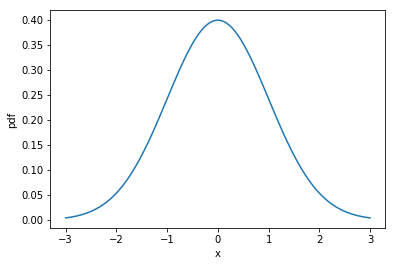

In [3]:
from scipy.stats import norm
x = np.linspace(-3,3, 100)
# on choisit 0 comme moyenne de la Gaussienne.
# (la Gaussienne est centrée sur 0)
# et 1 pour sa largeur, appelée sigma
plt.plot(x, norm.pdf(x, 0., 1.))
plt.xlabel('x'); plt.ylabel('pdf')

Dans cet exemple, $x$ est une **variable aléatoire** distribuée suivant cette pdf Gaussienne. Cela signifie que lorsque l'on tire au hasard une valeur de $x$, l'aire sous la courbe pour un certain intervalle en $x$ nous donne la probabilité que cette valeur tombe dans l'intervalle. 

Par conséquent, la surface totale sous la fonction (son intégrale) entre moins l'infini et plus l'infini est égale à 1. 

Nous pouvons voir que les valeur tirées aléatoirement pour $x$ auront une probabilité importante de tomber autour de 0. 

Pour la catégorie 0, nous choisissons une pdf Gaussienne centrée sur -1.5 avec sigma=1. Pour la catégorie 1, on centre la Gaussienne sur 1.5. Dans chaque catégorie, on construit 100 exemples en tirant aléatoirement 100 valeurs:

In [4]:
normal = np.random.normal
sigma = 1
x0 = normal(-1.5, sigma, 100)
x1 = normal(1.5, sigma, 100)
# étiquettes: 
y0 = np.zeros_like(x0)
y1 = np.ones_like(x1)

Ces deux échantillons peuvent être visualisés en traçant pour chaque exemple la catégorie en fonction de $x$

Text(0,0.5,'category')

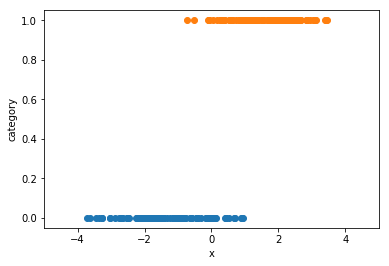

In [5]:
plt.xlim(-5,5)
plt.plot(x0, y0,'o')
plt.plot(x1, y1,'o')
plt.xlabel('x')
plt.ylabel('category')

Et nous pouvons aussi utiliser des histogrammes. Pour chaque catégorie, l'histogramme a 50 canaux, qui comptent le nombre d'exemples avec une valeur tombant dans le canal:

Text(0,0.5,'counts')

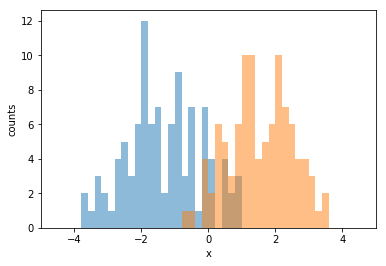

In [6]:
# plt.hist(sample1,bins=50, range=(-5,5))
plt.clf()
plt.xlim(-5,5)
plt.hist(x0,bins=50, range=(-5,5), alpha=0.5)
plt.hist(x1,bins=50, range=(-5,5), alpha=0.5)
plt.xlabel('x')
plt.ylabel('counts')

Ces deux échantillons semblent en effet suivre les pdf normales que nous avons choisies. Avec un plus grand nombre d'exemples dans chaque catégorie, chacun des deux histogrammes se rapprocherait de la pdf sous-jacente. 

À l'oeil, on voit que les deux échantillons peuvent être classés en fixant une barrière de séparation à $x=0$. On classera un exemple inconnu de valeur $x$ dans la catégorie 1 si $x>0$, et sinon dans la catégorie 0. 

Nous allons maintenant voir comment un réseau de neurones tout simple peut trouver la position de cette barrière de séparation pour nous. 

Mais avant cela, il nous faut parler de la fonction sigmoïde. 

## La sigmoïde 

La **sigmoïde**, aussi appelée **fonction logistique**, est essentielle dans les problèmes de classement binaires. À une dimension, elle s'exprime comme

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

et voici à quoi elle ressemble, en compagnie de nos échantillons: 

Text(0,0.5,'$\\sigma(z)$')

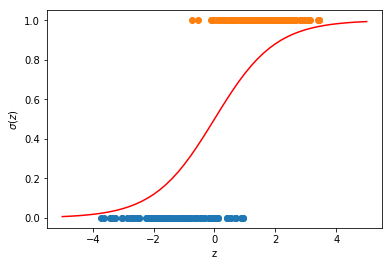

In [7]:
# définition des paramètres
b = 0
w = 1

def sigmoid(x1):
    # z est une fonction linéaire de x1
    z = w*x1 + b
    return 1 / (1+np.exp(-z))

# tableau contenant des valeurs de x espacées 
# régulièrement entre -5 et 5
linx = np.linspace(-5,5,51)
plt.plot(x0, np.zeros_like(x0),'o')
plt.plot(x1, np.ones_like(x1),'o')
plt.plot(linx, sigmoid(linx), color='red')
plt.xlabel('z')
plt.ylabel(r'$\sigma(z)$')

Voyons ça plus en détails: 

* lorsque $z$ tend vers l'infini, $e^{-z}$ tend vers 0, et $\sigma (z)$ tend vers 1.
* lorsque $z$ tend vers moins l'infini, $e^{-z}$ tend vers l'infini, et $\sigma (z)$ tend vers 0.
* $\sigma(0) = 0.5$ car $e^0=1$.

Il est important de noter que la sigmoïde est bornée entre 0 et 1, comme une probabilité. Et en fait, dans les problèmes de classement binaires, la probabilité qu'un exemple appartienne à une catégorie donnée est produite par une sigmoïde. Pour classer nos exemples, nous pouvons simplement utiliser la sortie de la sigmoïde: un exemple donné de valeur $x$ sera classé dans la catégorie 1 si $\sigma(z) > 0.5$, et dans la catégorie 0 dans le cas contraire. 

Maintenant, vous pouvez revenir à la cellule de code ci-dessus, et jouer un peu avec les paramètres `b` et `w`, en refaisant le graphique chaque fois que vous changez l'un des paramètres. 

* $b$ est le **biais**. Changer le biais déplace simplement la sigmoïde le long de l'axe horizontal. Par exemple, si vous choisissez $b=1$ et $w=1$, alors $z = wx + b = 0$ à $x=-1$, et c'est là que la sigmoïde prendra la valeur 0.5. 
* $w$ est le **poids** de la variable $x$. Si vous l'augmentez, la sigmoïde évoluera plus rapidement en fonction de $x$, et deviendra plus abrupte.  

Pour que la classification marche bien avec nos échantillons, on voit que le biais $b$ doit être égal à 0, et que le poids $w$ n'a aucune importance. Cela ne sera pas le cas en général. 

## Le réseau de neurones le plus simple au monde

Nous allons construire le réseau de neurones le plus simple possible pour classifier nos exemples. 

* Chaque exemple a une seule variable, donc nous avons besoin d'un seul noeud sur la couche d'entrée
* Nous n'allons pas utiliser de couche cachée, car cela compliquerait inutilement le réseau
* Il y a deux catégories, et la sortie du réseau doit donc être une seule valeur entre 0 et 1, qui sera la probabilité $p$ pour un exemple d'appartenir à la catégorie 1. Et donc, la probabilité d'appartenir à la catégorie 0 est simplement $1-p$. Par conséquent, il nous faut un seul neurone de sortie, le seul neurone de notre réseau. 

La sigmoïde nous sera utile. En effet, elle donne une valeur entre 0 et 1 qui peut être utilisée comme probabilité de classification, comme nous l'avons vu précédemment. 

Nous pouvons représenter notre réseau de la façon suivante: 

![Neural network with 1 neuron](https://github.com/cbernet/maldives/raw/master/images/one_neuron.png)

Dans le neurone de sortie: 

* la première boîte effectue juste un changement de variable, et calcule **l'entrée pondérée** $z$ du neurone. 
* la deuxième boîte applique la **fonction d'activation** à l'entrée pondérée. Ici, nous choisissons la sigmoïde $\sigma (z) = 1/(1+e^{-z})$ comme fonction d'activation. 

Ce réseau simple a seulement 2 paramètres réglables, le poids $w$ et le biais $b$, tous deux utilisés dans la première boîte. Nous voyons en particulier que lorsque le biais est grand, le neurone sera toujours activé, quelque soit $x$. Au contraire, pour des biais très négatifs, le neurone est mort. 

Il est intéressant de réaliser que ce réseau est une simple fonction de $x$,  

$$f(x) = \sigma(z) = \sigma(wx+b)$$

Les réseaux de neurones avec aucune couche cachée et une fonction d'activation sigmoïde dans les neurones de sortie sont en fait utilisés très fréquemment dans les problèmes de classement, sous le nom de **régression logistique**. 

Dans les prochaines sections, nous allons d'abord utiliser la régression logistique de scikit-learn pour classer nos exemples, et nous répéterons l'exercice avec le réseau à un neurone.

Mais d'abord, nous devons construire un seul échantillon contenant les exemples des deux catégories: 

In [17]:
# création d'un tableau 1D contenant
# les examples de x0 et x1
x = np.concatenate((x0, x1))
# x est un tableau 1D.
# on le transforme en un tableau 2D avec une valeur par ligne.
# la première dimension indexe les exemples
# la deuxième contient la valeur pour chaque exemple. 
x = np.c_[x]
# création d'un tableau 1D avec les étiquettes 
# y0 et y1
y = np.concatenate((y0, y1))

## La régression logistique

In [9]:
from sklearn.linear_model import LogisticRegression

Entraînons la régression logistique sur les données:

In [10]:
clf = LogisticRegression(random_state=0, solver='lbfgs').fit(x,y)

Maintenant, nous pouvons prédire la probabilité pour un exemple d'appartenir à une catégorie. Pour $x=4$, nous sommes très loin dans la catégorie 1, et la régression estime la probabilité pour cette catégorie à plus de 99.9%:

In [18]:
clf.predict_proba([[4]])

array([[9.95607890e-05, 9.99900439e-01]])

Traçons maintenant la probabilité prédite en fonction de $x$, ainsi que nos échantillons. D'abord, nous devons créer un tableau avec 100 valeurs de $x$ espacées régulièrement, et le convertir en tableau 2D avec une valeur de $x$ sur chaque ligne.

In [19]:
linx = np.c_[np.linspace(-5, 5, 100)]

Les probabilités pour chaque valeur de $x$ sont: 

In [20]:
# predict_proba prend un tableau d'exemples, 
# c'est à dire un tableau 2D
prob = clf.predict_proba(linx)
# extraction de la deuxième probabilité
# (pour la catégorie 1), pour chaque exemple
# nous obtenons un tableau 2D 
# et le transformons en tableau 1D de taille 100:
prob = prob[:,1].reshape(len(linx))

💡 **Les opérations ci-dessus peuvent ne pas vous sembler très claires. Si c'est le case, vous pouvez toujours imprimer un tableau ou sa forme (prob.shape) pour voir à quoi il ressemble. Je fais ça très régulièrement!** 

Finalement, on peut tracer la probabilité en fonction de $x$

Text(0,0.5,'category probability')

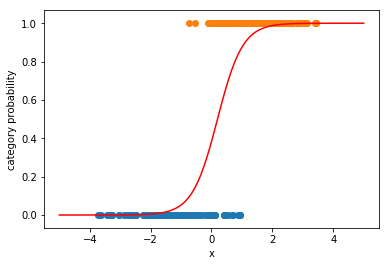

In [21]:
# both linx and prob must be 1D
plt.plot(linx, prob, color='red')
plt.scatter(x0, y0)
plt.scatter(x1, y1)
plt.xlabel('x')
plt.ylabel('category probability')

On voit que la sortie de la régression est en effet une sigmoïde. 
Le biais est proche de zéro, et il semble que le classement marchera bien. 

## Le réseau à un neurone

Nous allons maintenant refaire le même exercice avec le réseau de neurones de classification de scikit-learn et: 

* aucune couche cachée
* une sigmoïde (ou fonction logistique) comme fonction d'activation. 

scikit-learn se rendra compte par lui-même que nous n'avons qu'une seule variable pour chaque exemple, et que nous voulons faire une **classification binaire** (en deux catégories). Il créera alors automatiquement le réseau avec un seul noeud sur la couche d'entrée et un seul neurone sur la couche de sortie. 

In [22]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(), 
                    alpha = 0.001,
                    activation='logistic', 
                    solver='lbfgs', random_state=1)

mlp.fit(x,y)

MLPClassifier(activation='logistic', alpha=0.001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Text(0,0.5,'category probability')

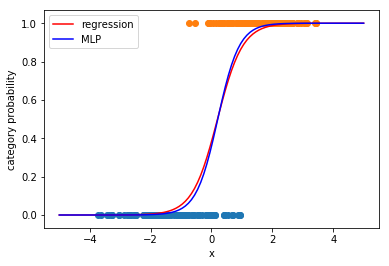

In [23]:
prob_mlp = mlp.predict_proba(linx)
# take the second probability 
# (to be in category 1) for each example
# and reshape it to a 1D array of size 100
prob_mlp = prob_mlp[:,1].reshape(len(linx))
plt.plot(linx, prob, color='red', label='regression')
plt.plot(linx, prob_mlp, color='blue', label='MLP')
plt.scatter(x0, y0)
plt.scatter(x1, y1)
plt.legend()
plt.xlabel('x')
plt.ylabel('category probability')

Comme prévu, les résultats sont très similaires à ceux de la régression logistique. Les différences sont probablement dues aux opérations effectuées en interne par le MLPClassifier. 

Pour être franc, je ne sais pas trop ce qui se passe là-dedans et je n'ai aucune intention de creuser le sujet. 
En effet, le [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) est trop opaque à mon goût, et nous utiliserons de toutes façons principalement [keras](https://thedatafrog.com/neural-network-keras/) pour travailler avec les réseaux de neurones. 


## Et ensuite? 

Dans cet article, vous avez appris: 

* ce qu'il y a dans un neurone, et en particulier ce qu'est la fonction d'activation sigmoïde;
* que la sigmoïde est un choix naturel pour les neurones de la dernière couche d'un réseau dédié au classement binaire;
* qu'un réseau de neurones n'est rien de plus qu'une fonction de ses variables d'entrées; 
* qu'un seul neurone peut tout à fait suffire, et est équivalent à une régression logistique.

La prochaine fois, nous referons cet exercice en 2D. Nous parlerons de la linéarité des problèmes de classification, et de la nécessité d'introduire dans certains cas une non-linéarité grâce aux couches cachées. 
